In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import joblib


In [2]:
# Load data from .npy files
X = np.load("../data/X.npy")  
Y = np.load("../data/Y.npy")

In [3]:
# use the past 50 timesteps to predict the next one
time_steps = 50

# Create sequences
X_seq, Y_seq = [], []
for i in range(len(X) - time_steps):
    X_seq.append(X[i:i+time_steps])  
    Y_seq.append(Y[i+time_steps])    

# Convert to NumPy arrays
X_seq, Y_seq = np.array(X_seq), np.array(Y_seq)
Y_seq = Y_seq.reshape(-1, 1)

print("Data reshaping for LSTM completed!")
# Should be samples, time_steps, features
print("X_seq shape:", X_seq.shape)  
# Should be samples, 1
print("Y_seq shape:", Y_seq.shape)  

Data reshaping for LSTM completed!
X_seq shape: (4951, 50, 5)
Y_seq shape: (4951, 1)


In [4]:
# Define the LSTM model
model = Sequential([
    # First layer of  LSTM Extract Feature
    LSTM(64, return_sequences=True, input_shape=(time_steps, X_seq.shape[2])),  
    # Dropout for regularization
    Dropout(0.2),  
    # Second layer of LSTM Process the extracted Feature
    LSTM(64, return_sequences=False),  
    # Dropout for regularization
    Dropout(0.2),
    # Dense Hidden Layer, transforms inputs from the previous layer
    Dense(32, activation='relu'),  
    # Output layer Predicting the "Close" price
    Dense(1)  
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

print("LSTM model defined and compiled!")


LSTM model defined and compiled!


c:\Users\chira\OneDrive\Documents\SEM6\CS 354N\ML LEARNING\backtest-and-risk-assessment\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
# Train the model
history = model.fit(X_seq, Y_seq, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

print("Model training completed!")


Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - loss: 0.0272 - val_loss: 0.0016
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0011 - val_loss: 9.3377e-04
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 9.4656e-04 - val_loss: 0.0013
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 8.7156e-04 - val_loss: 0.0024
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 8.0958e-04 - val_loss: 0.0014
Epoch 9/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 7.6286e-04 - val_loss: 0.0015
Epoch 10/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 5.7655e-04 - val_loss: 0.0014
Epoch 11/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 6.4319e-04 - val_loss: 0.0011
Epoch 12/50


In [6]:
# Save the trained LSTM model
model.save("../models/lstm_model.h5")

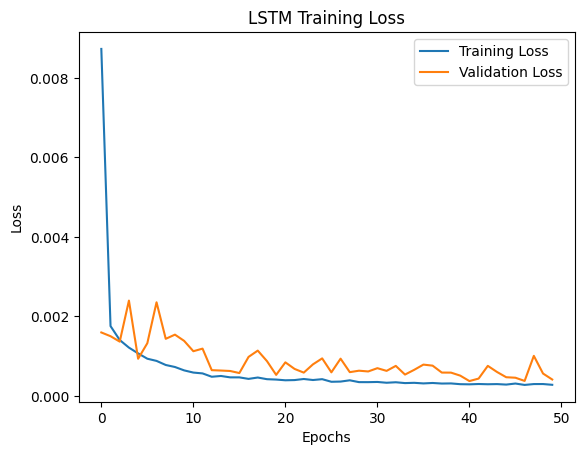

In [7]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM Training Loss')
plt.show()


In [8]:
# Predict using LSTM
train_predictions = model.predict(X_seq)  

155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


In [9]:
# Load the saved scaler
scaler = joblib.load("../models/scaler.pkl")

In [10]:
# Inverse transform the predictions
# Extract only the Close column
train_predictions = scaler.inverse_transform(
    np.concatenate((np.zeros((len(train_predictions), 3)),  
                    train_predictions.reshape(-1, 1),
                    np.zeros((len(train_predictions), 1))),  
                   axis=1)  
)[:, 3]  

# Inverse transform actual prices
actual_prices = scaler.inverse_transform(
    np.concatenate((np.zeros((len(Y_seq), 3)),  
                    Y_seq.reshape(-1, 1),
                    np.zeros((len(Y_seq), 1))),  
                   axis=1)
)[:, 3]

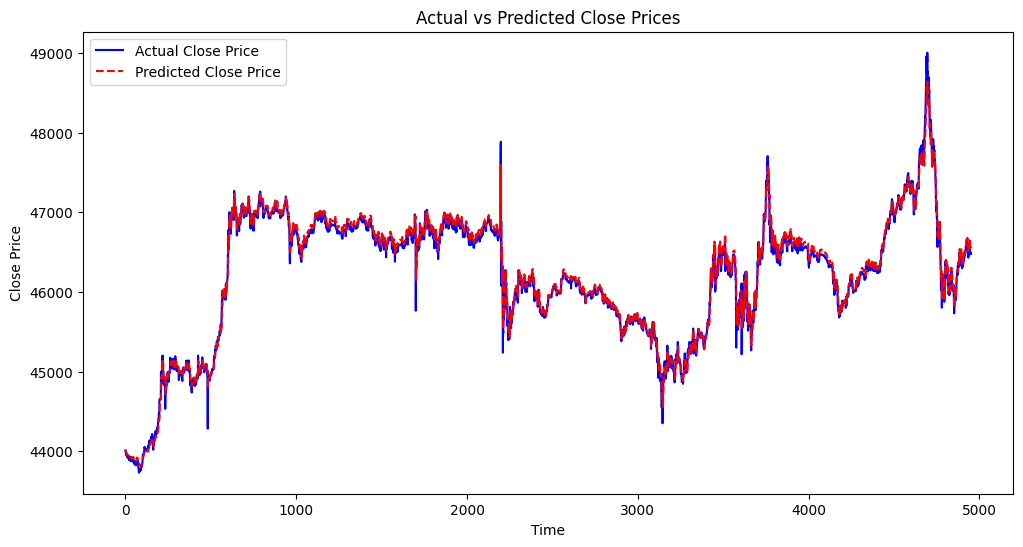

In [11]:
# plot the given Actual Close Price and Predicted Close Price:

plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label="Actual Close Price", color="blue")
plt.plot(train_predictions, label="Predicted Close Price", color="red", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.title("Actual vs Predicted Close Prices")
plt.show()
